# Baseline 2-Staged Least Squares Instrumental Variables Regression using Cornelia's Randomized Medical Data

- Using year, month, county as fixed effects. But interact year_trend * month_county.
- Include control diagnoses.

In [91]:
# optional. I'm getting annoying warnings that I just want to ignore:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# basics
import pandas as pd 
import numpy as np
import os 
import re
from datetime import datetime
from tqdm.notebook import tqdm
tqdm.pandas()
import requests
import urllib

# plotting
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import plotly.express as px
import seaborn as sns

# modeling
from patsy import dmatrices
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.sandbox.regression.gmm import IV2SLS

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [92]:
# download this extra package from here: https://github.com/bashtage/linearmodels
#!pip install linearmodels
# from linearmodels.iv import IV2SLS as IV2SLS_v2

In [93]:
# local or gdrive
path_source = 'work'

if path_source == 'gdrive':
  from google.colab import drive
  drive.mount('/content/gdrive')
  data_path = '/content/gdrive/MyDrive/Classes/W210_capstone/W210_Capstone/Data'
  #env_path = '/content/gdrive/MyDrive/.env'
  
elif path_source == 'local':
  data_path = '/Users/tj/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/Data'
  #env_path = '/content/gdrive/MyDrive/.env'

elif path_source == 'work':
  data_path = '/Users/trevorjohnson/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/Data'

# Read in data

In [94]:
# read in our modeling data
df = pd.read_csv(os.path.join(data_path, 'modeling_data/modeling_data_2022-10-18.csv'))

# read in cornelia's healthcare data
df1 = pd.read_csv(os.path.join(data_path, 'medical/hematopoietic_cancers.csv')).iloc[:,1:]
df2 = pd.read_csv(os.path.join(data_path, 'medical/pediatric_vasculitis.csv')).iloc[:,1:]
df3 = pd.read_csv(os.path.join(data_path, 'medical/type_1_diabetes.csv')).iloc[:,1:]
df4 = pd.read_csv(os.path.join(data_path, 'medical/resp_cardio.csv')).iloc[:,1:]
df5 = pd.read_csv(os.path.join(data_path, 'medical/injuries_accidents.csv')).iloc[:,1:]

# Data clean

Clean med data

In [95]:
# get all distinct patzip_year_month
all_pats = df1['patzip_year_month'].to_list() + \
  df2['patzip_year_month'].to_list() + \
  df3['patzip_year_month'].to_list() + \
  df4['patzip_year_month'].to_list() + \
  df5['patzip_year_month'].to_list() 
all_pats = list(set(all_pats))
df_med = pd.DataFrame({'patzip_year_month': all_pats})

# rename columns more intuitively
df1 = df1.rename(columns={'number_of_visits': 'number_of_visits_hem_cancers'})
df2 = df2.rename(columns={'number_of_visits': 'number_of_visits_vasc'})
df3 = df3.rename(columns={'number_of_visits': 'number_of_visits_diab'})
df4 = df4.rename(columns={'number_of_visits': 'number_of_visits_resp_cardio'})
df5 = df5.rename(columns={'number_of_visits': 'number_of_visits_injuries'})

# now join all the diagnoses on this dataset
df_med = df_med\
  .merge(df1, on='patzip_year_month', how='left')\
  .merge(df2, on='patzip_year_month', how='left')\
  .merge(df3, on='patzip_year_month', how='left')\
  .merge(df4, on='patzip_year_month', how='left')\
  .merge(df5, on='patzip_year_month', how='left')

df_med.head(3)

,patzip_year_month,hematopoietic_cancers,number_of_visits_hem_cancers,pediatric_vasculitis,number_of_visits_vasc,type_1_diabetes,number_of_visits_diab,resp_cardio,number_of_visits_resp_cardio,injuries_accidents,number_of_visits_injuries
0,94619-2008-6,NaN,NaN,NaN,NaN,NaN,NaN,1.0,127.0,1.0,130.0
1,92835-2006-11,NaN,NaN,1.0,17.0,NaN,NaN,1.0,124.0,1.0,118.0
2,91723-2009-12,NaN,NaN,NaN,NaN,NaN,NaN,1.0,140.0,1.0,125.0


Join med data

In [96]:
df['year_month'] = df['year_month'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))

df['zip_year_month'] = df['school_zip'].astype(str) + '-' +\
  df['year_month'].dt.year.astype(str) + '-' +\
  df['year_month'].dt.month.astype(str)

df = pd.merge(df, df_med, left_on='zip_year_month', right_on='patzip_year_month', how='left')

# for missing med data, assume there were 0 cases:
med_vars = ['hematopoietic_cancers', 'number_of_visits_hem_cancers', 
  'pediatric_vasculitis', 'number_of_visits_vasc', 
  'type_1_diabetes', 'number_of_visits_diab',
  'resp_cardio', 'number_of_visits_resp_cardio',
  'injuries_accidents', 'number_of_visits_injuries'
  ]
for var in med_vars:
  df[var] = df[var].fillna(0)

# fixing month datatype
df['month'] = df['month'].astype(str)

print(df.shape[0])

311163


Var transformations

In [97]:
# Create response variables, which is visits / population
df['y_hematopoietic'] = df['number_of_visits_hem_cancers'] / df['total_pop_under19']
df['y_vasculitis'] = df['number_of_visits_vasc'] / df['total_pop_under19']
df['y_diabetes'] = df['number_of_visits_diab'] / df['total_pop_under19']
df['y_resp_cardio'] = df['number_of_visits_resp_cardio'] / df['total_pop_under19']
df['y_injuries'] = df['number_of_visits_injuries'] / df['total_pop_under19']

# Make treatment var normally distributed by taking log(1+x)
df['pm25_log'] = np.log1p(df['pm25'])

# create year trend feature
df['year_trend'] = df['year'] - 1999

# create county_month
df['county_month'] = df.apply(lambda df: df['month'].rjust(2, '0') + '_' + df['school_county_v2'], axis=1)

# First stage regression - Predict pm2.5 levels

- QQplot says the residuals are skewed right and have heavy tails (same with logged version, but less skewed).

In [98]:
# get data into right model form
y, X = dmatrices('pm25 ~ avg_wind_alignment_cosine + school_county_v2 + month + year_trend * C(county_month)', 
  data=df, return_type='dataframe')

RMSE: 4.323664445668356
                            OLS Regression Results                            
Dep. Variable:                   pm25   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     203.8
Date:                Sun, 23 Oct 2022   Prob (F-statistic):               0.00
Time:                        20:56:14   Log-Likelihood:            -8.9710e+05
No. Observations:              311163   AIC:                         1.797e+06
Df Residuals:                  309770   BIC:                         1.812e+06
Df Model:                        1392                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

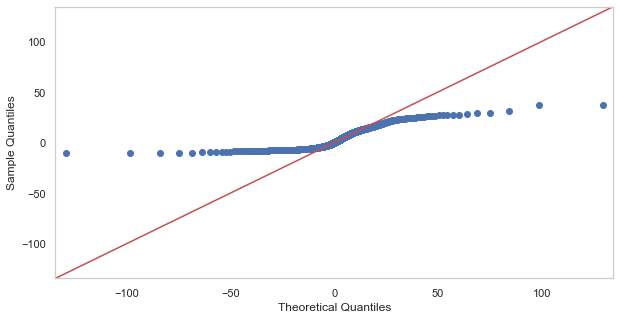

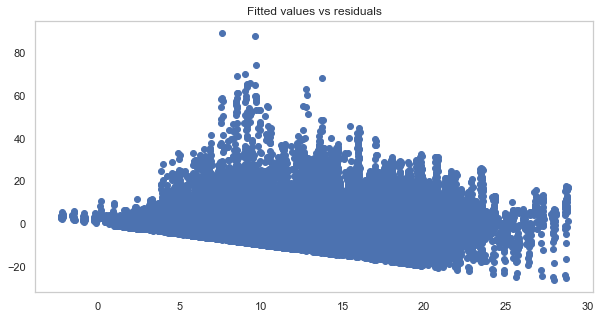

In [99]:
# rearrange cols a bit
X = X[['avg_wind_alignment_cosine'] + [i for i in X.columns if not re.search('avg_wind_alignment_cosine', i)]]
fit1 = sm.OLS(y, X).fit()

# add fitted y value to our dataset
df['yhat_pm25'] = fit1.fittedvalues.values

# resid
resids = fit1.resid
resids_and_fitted = pd.DataFrame({'resids': fit1.resid, 'fitted': fit1.fittedvalues.values})

#p-values
#fit1.pvalues

# rmse
rmse = np.mean(np.array(df['yhat_pm25'] - df['pm25']) ** 2) ** .5
print(f'RMSE: {rmse}')

# model summary
print(fit1.summary())

# qqplot
import scipy.stats as stats
plt.rcParams["figure.figsize"] = (10,5)
fig = sm.qqplot(resids, stats.t, fit=True, line="45")
plt.show()

# resid vs fitted
plt.scatter(resids_and_fitted['fitted'], resids_and_fitted['resids'])
plt.title('Fitted values vs residuals')
plt.show()

In [84]:
# Save fitted model
fit1.save(os.path.join(data_path, '../fitted_models/2022-10-23/stage1_ols.pickle'), remove_data=True)

# note, load model like this
# from statsmodels.iolib.smpickle import load_pickle
# fitted_model = load_pickle(os.path.join(data_path, 'fitted_models/2022-10-23/stage1_ols.pickle'))

<AxesSubplot:>

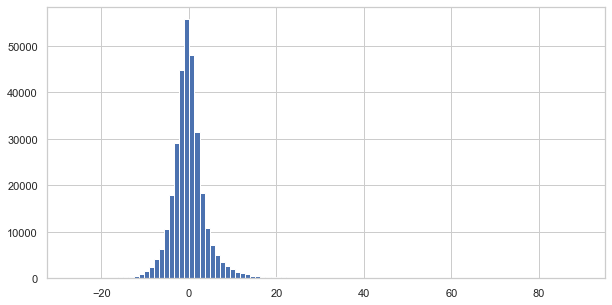

In [100]:
# histogram of the residuals
resids_and_fitted['resids'].hist(bins=100)

In [101]:
def get_ols_res(fitted):
  fit_res = fitted.params.to_frame().reset_index()
  fit_res.columns = ['variable', 'coef']
  fit_res['p_value'] = fitted.pvalues.values
  df_ci = fitted.conf_int().reset_index()
  df_ci.columns = ['variable','95_ci_lower', '95_ci_upper']
  fit_res = pd.merge(fit_res, df_ci, on='variable', how='inner')
  return fit_res

get_ols_res(fit1).head(1)

,variable,coef,p_value,95_ci_lower,95_ci_upper
0,avg_wind_alignment_cosine,0.097724,9.321278e-13,0.0709,0.124548


In [102]:
#get_ols_res(fit1).head(1).to_markdown()
print(get_ols_res(fit1).head(1))

                    variable      coef       p_value  95_ci_lower  95_ci_upper
0  avg_wind_alignment_cosine  0.097724  9.321278e-13       0.0709     0.124548


# Second Stage Regression

- Stage 1 of the least squares regression: $\hat{x} = z \delta$.
  - $\hat{x}$ = Predicted pm2.5 amounts ($\hat{pm2.5}$). We'll use this predicted var to predict our final Y, health outcomes. 
  - $z$ = Instrument = `avg_wind_alignment_cosine`. But this right hand side of the equation should also include all other exogenous (x) vars. 
  
- Stage 2 of the equation: $\hat{y} = \hat{x} \beta$
  - $\hat{y}$ = predicted medical outcome
  - $\hat{x}$ = predicted pm2.5 amt from the first stage. But we also should include the other exogenous vars. 

In [103]:
# drop instrument, and add x_hat to the X matrix
X = X.drop(columns='avg_wind_alignment_cosine')
X['yhat_pm25'] = df['yhat_pm25']
X = X[['yhat_pm25'] + [i for i in X.columns if not re.search('yhat_pm25', i)]] # put our pred pm25 in front

                            OLS Regression Results                            
Dep. Variable:        y_hematopoietic   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.111
Date:                Sun, 23 Oct 2022   Prob (F-statistic):          1.05e-111
Time:                        20:59:48   Log-Likelihood:             1.4632e+06
No. Observations:              311163   AIC:                        -2.924e+06
Df Residuals:                  309770   BIC:                        -2.909e+06
Df Model:                        1392                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

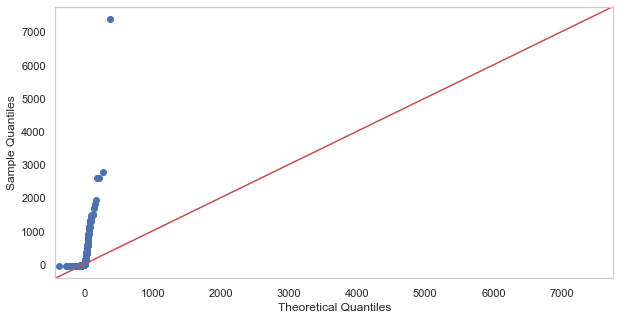

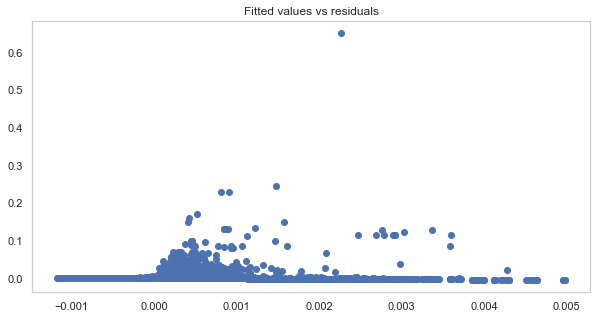

In [107]:
# fit model
y = df['y_hematopoietic']
fit2_hema = sm.OLS(y, X).fit()

# add fitted y value to our dataset
df['yhat_hematopoietic'] = fit2_hema.fittedvalues.values
# resid
resids = fit2_hema.resid
resids_and_fitted_hema = pd.DataFrame({'resids': fit2_hema.resid, 'fitted': fit2_hema.fittedvalues.values})

# p-value
# print(f'p-value: {fit2_hema.pvalues.to_frame().iloc[-1][0]}')

print(fit2_hema.summary())

# qqplot
import scipy.stats as stats
plt.rcParams["figure.figsize"] = (10,5)
fig = sm.qqplot(resids, stats.t, fit=True, line="45")
plt.show()

# resid vs fitted
plt.scatter(resids_and_fitted_hema['fitted'], resids_and_fitted_hema['resids'])
plt.title('Fitted values vs residuals')
plt.show()

# save results 
fit2_hema.save(os.path.join(data_path, '../fitted_models/2022-10-23/stage2_ols_hematopoietic.pickle'), remove_data=True)

                            OLS Regression Results                            
Dep. Variable:           y_vasculitis   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.030
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           3.80e-99
Time:                        21:00:51   Log-Likelihood:             1.5950e+06
No. Observations:              311163   AIC:                        -3.187e+06
Df Residuals:                  309770   BIC:                        -3.172e+06
Df Model:                        1392                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

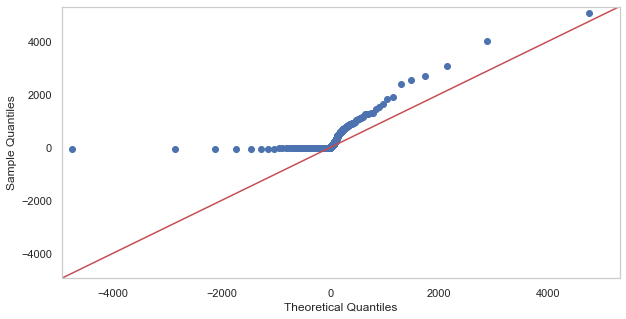

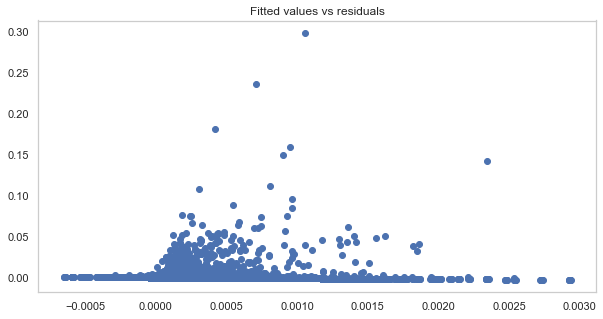

In [108]:
y = df['y_vasculitis']
fit2_vasc = sm.OLS(y, X).fit()

# add fitted y value to our dataset
df['yhat_vasculitis'] = fit2_vasc.fittedvalues.values

# resid
resids = fit2_vasc.resid
resids_and_fitted_vasc = pd.DataFrame({'resids': fit2_vasc.resid, 'fitted': fit2_vasc.fittedvalues.values})

print(fit2_vasc.summary())

# p-value
# print(f'p-value: {fit2_vasc.pvalues.to_frame().iloc[-1][0]}')

# qqplot
import scipy.stats as stats
plt.rcParams["figure.figsize"] = (10,5)
fig = sm.qqplot(resids, stats.t, fit=True, line="45")
plt.show()

# resid vs fitted
plt.scatter(resids_and_fitted_vasc['fitted'], resids_and_fitted_vasc['resids'])
plt.title('Fitted values vs residuals')
plt.show()

# save results 
fit2_vasc.save(os.path.join(data_path, '../fitted_models/2022-10-23/stage2_ols_vasculitis.pickle'), remove_data=True)

                            OLS Regression Results                            
Dep. Variable:             y_diabetes   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.248
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           6.27e-10
Time:                        21:01:53   Log-Likelihood:             1.1564e+06
No. Observations:              311163   AIC:                        -2.310e+06
Df Residuals:                  309770   BIC:                        -2.295e+06
Df Model:                        1392                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

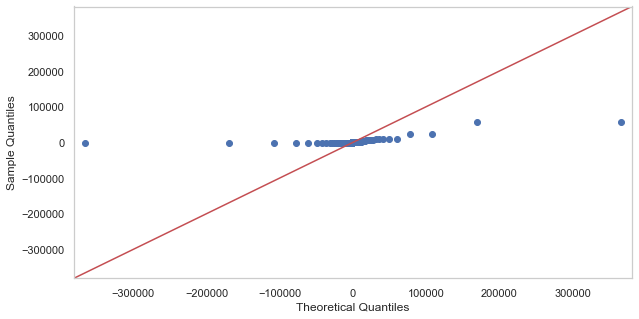

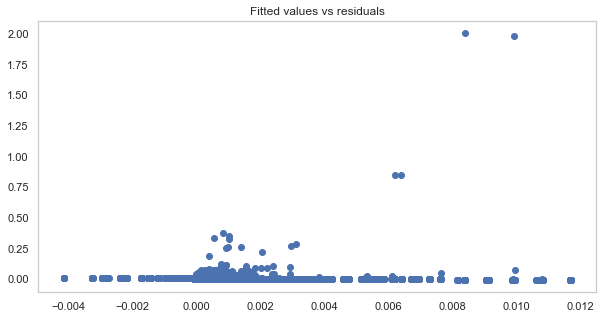

In [109]:
# fit model
y = df['y_diabetes']
fit2_diab = sm.OLS(y, X).fit()

# add fitted y value to our dataset
df['yhat_diabetes'] = fit2_diab.fittedvalues.values 

resids_and_fitted_diab = pd.DataFrame({'resids': fit2_diab.resid, 'fitted': fit2_diab.fittedvalues.values})

print(fit2_diab.summary())

# p-value
# print(f'p-value: {fit2_diab.pvalues.to_frame().iloc[-1][0]}')

# qqplot
import scipy.stats as stats
plt.rcParams["figure.figsize"] = (10,5)
fig = sm.qqplot(fit2_diab.resid, stats.t, fit=True, line="45")
plt.show()

# resid vs fitted
plt.scatter(resids_and_fitted_diab['fitted'], resids_and_fitted_diab['resids'])
plt.title('Fitted values vs residuals')
plt.show()

# save results 
fit2_diab.save(os.path.join(data_path, '../fitted_models/2022-10-23/stage2_ols_diabetes.pickle'), remove_data=True)

                            OLS Regression Results                            
Dep. Variable:          y_resp_cardio   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     4.406
Date:                Sun, 23 Oct 2022   Prob (F-statistic):               0.00
Time:                        21:02:56   Log-Likelihood:            -2.1273e+05
No. Observations:              311163   AIC:                         4.282e+05
Df Residuals:                  309770   BIC:                         4.431e+05
Df Model:                        1392                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

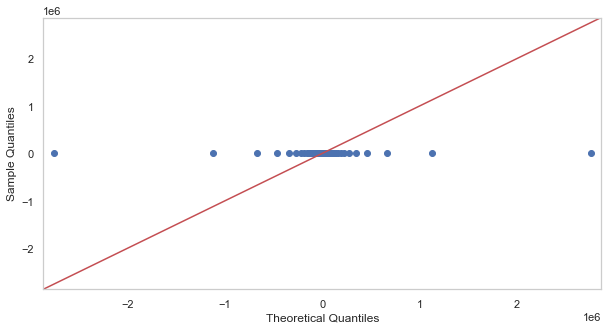

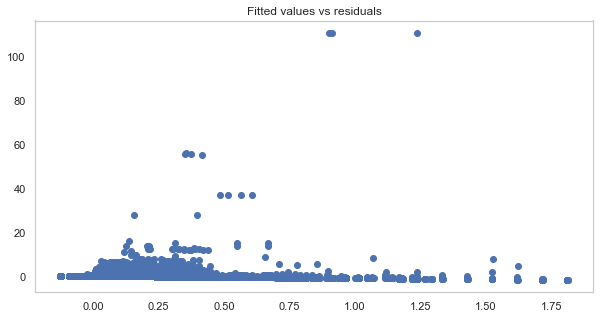

In [110]:
# fit model
y = df['y_resp_cardio']
fit2_resp_cardio = sm.OLS(y, X).fit()

# add fitted y value to our dataset
df['yhat_resp_cardio'] = fit2_resp_cardio.fittedvalues.values 
resids_and_fitted_resp_cardio = pd.DataFrame({'resids': fit2_resp_cardio.resid, 'fitted': fit2_resp_cardio.fittedvalues.values})
print(fit2_resp_cardio.summary())

# p-value
# print(f'p-value: {fit2_resp_cardio.pvalues.to_frame().iloc[-1][0]}')

# qqplot
import scipy.stats as stats
plt.rcParams["figure.figsize"] = (10,5)
fig = sm.qqplot(fit2_resp_cardio.resid, stats.t, fit=True, line="45")
plt.show()

# resid vs fitted
plt.scatter(resids_and_fitted_resp_cardio['fitted'], resids_and_fitted_resp_cardio['resids'])
plt.title('Fitted values vs residuals')
plt.show()

# save results 
fit2_resp_cardio.save(os.path.join(data_path, '../fitted_models/2022-10-23/stage2_ols_resp_cardio.pickle'), remove_data=True)

                            OLS Regression Results                            
Dep. Variable:             y_injuries   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     9.122
Date:                Sun, 23 Oct 2022   Prob (F-statistic):               0.00
Time:                        21:04:02   Log-Likelihood:            -2.0498e+05
No. Observations:              311163   AIC:                         4.127e+05
Df Residuals:                  309770   BIC:                         4.276e+05
Df Model:                        1392                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

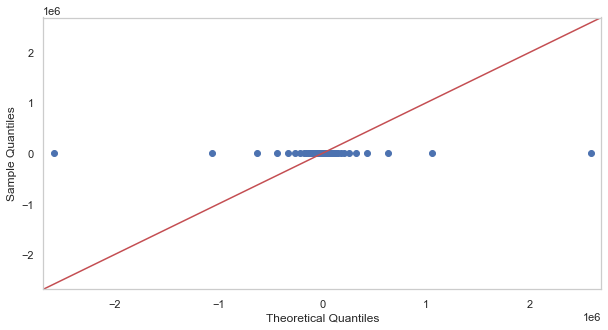

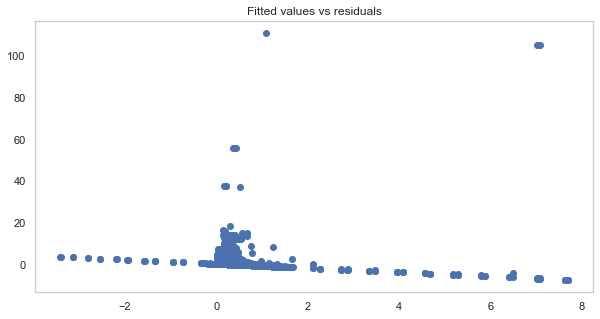

In [111]:
# fit model
y = df['y_injuries']
fit2_injuries = sm.OLS(y, X).fit()

# add fitted y value to our dataset
df['yhat_injuries'] = fit2_injuries.fittedvalues.values 

resids_and_fitted_injuries = pd.DataFrame({'resids': fit2_injuries.resid, 'fitted': fit2_injuries.fittedvalues.values})
print(fit2_injuries.summary())

# p-value
# print(f'p-value: {fit2_injuries.pvalues.to_frame().iloc[-1][0]}')

# qqplot
import scipy.stats as stats
plt.rcParams["figure.figsize"] = (10,5)
fig = sm.qqplot(fit2_injuries.resid, stats.t, fit=True, line="45")
plt.show()

# resid vs fitted
plt.scatter(resids_and_fitted_injuries['fitted'], resids_and_fitted_injuries['resids'])
plt.title('Fitted values vs residuals')
plt.show()

# save results 
fit2_injuries.save(os.path.join(data_path, '../fitted_models/2022-10-23/stage2_ols_injuries.pickle'), remove_data=True)

## Save All Results

In [54]:
df.to_csv(os.path.join(data_path, 'modeling_data/modeling_data_results_2022-10-23.csv'), index=False)

# Results Summary
- Use these printouts to easily paste key stats onto our poster

In [112]:
def get_ols_res(fitted):
  fit_res = fitted.params.to_frame().reset_index()
  fit_res.columns = ['variable', 'coef']
  fit_res['p_value'] = fitted.pvalues.values
  df_ci = fitted.conf_int().reset_index()
  df_ci.columns = ['variable','95_ci_lower', '95_ci_upper']
  fit_res = pd.merge(fit_res, df_ci, on='variable', how='inner')
  return fit_res

In [113]:
print(get_ols_res(fit2_hema).head(3))

                     variable      coef   p_value  95_ci_lower  95_ci_upper
0                   yhat_pm25  0.000133  0.060778    -0.000006     0.000273
1                   Intercept -0.002065  0.066249    -0.004269     0.000139
2  school_county_v2[T.Alpine]  0.000939  0.107960    -0.000206     0.002085


In [114]:
print(get_ols_res(fit2_vasc).head(3))

                     variable      coef   p_value  95_ci_lower  95_ci_upper
0                   yhat_pm25 -0.000109  0.019557    -0.000200    -0.000017
1                   Intercept  0.001759  0.016829     0.000317     0.003202
2  school_county_v2[T.Alpine] -0.000815  0.033184    -0.001564    -0.000065


In [115]:
print(get_ols_res(fit2_diab).head(3))

                     variable      coef   p_value  95_ci_lower  95_ci_upper
0                   yhat_pm25 -0.000133  0.486886    -0.000506     0.000241
1                   Intercept  0.002026  0.501440    -0.003880     0.007931
2  school_county_v2[T.Alpine] -0.000899  0.565820    -0.003969     0.002170


In [116]:
print(get_ols_res(fit2_resp_cardio).head(3))

                     variable      coef   p_value  95_ci_lower  95_ci_upper
0                   yhat_pm25  0.015776  0.309615    -0.014657     0.046209
1                   Intercept -0.240872  0.326460    -0.721985     0.240241
2  school_county_v2[T.Alpine]  0.107894  0.397703    -0.142150     0.357939


In [117]:
print(get_ols_res(fit2_injuries).head(3))

                     variable      coef   p_value  95_ci_lower  95_ci_upper
0                   yhat_pm25  0.047174  0.001841     0.017490     0.076858
1                   Intercept -0.735890  0.002116    -1.205175    -0.266605
2  school_county_v2[T.Alpine]  0.342750  0.005881     0.098854     0.586647


# Verify the Exclusion Restriction
- Exclusion restriction: Our instrument (wind bearing) cannot be correlated to the residuals from the 2nd stage regression. 


                    wind_bearing   hema_resids   vasc_resids   diab_resids  \
wind_bearing        1.000000e+00 -1.236027e-16  1.155905e-16  5.966596e-17   
hema_resids        -1.236027e-16  1.000000e+00  2.056838e-02  5.797023e-04   
vasc_resids         1.155905e-16  2.056838e-02  1.000000e+00  6.532641e-04   
diab_resids         5.966596e-17  5.797023e-04  6.532641e-04  1.000000e+00   
resp_cardio_resids -5.843542e-17  7.013851e-03  5.849211e-03  6.222753e-02   
injuries_resids     3.507041e-18  5.221488e-03  2.569402e-03  3.462874e-02   

                    resp_cardio_resids  injuries_resids  
wind_bearing             -5.843542e-17     3.507041e-18  
hema_resids               7.013851e-03     5.221488e-03  
vasc_resids               5.849211e-03     2.569402e-03  
diab_resids               6.222753e-02     3.462874e-02  
resp_cardio_resids        1.000000e+00     9.861661e-02  
injuries_resids           9.861661e-02     1.000000e+00  


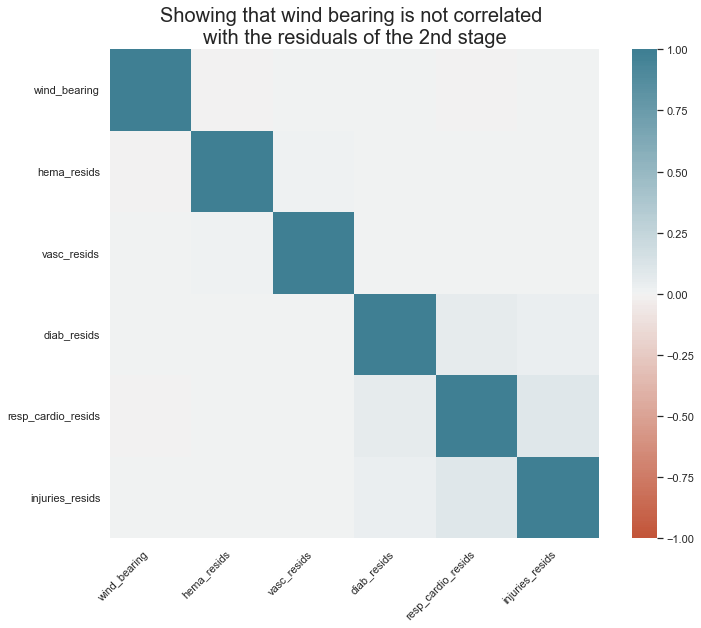

In [118]:
df_corr = pd.DataFrame({
  'wind_bearing': df['avg_wind_alignment_cosine'].values, 
  'hema_resids': resids_and_fitted_hema.resids.values,
  'vasc_resids': resids_and_fitted_vasc.resids.values, 
  'diab_resids': resids_and_fitted_diab.resids.values,
  'resp_cardio_resids': resids_and_fitted_resp_cardio.resids.values,
  'injuries_resids': resids_and_fitted_injuries.resids.values
}).corr()

# plot the results
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(df_corr, vmin=-1, center=0, vmax=1, cmap=sns.diverging_palette(20, 220, n=200), square=True)

ax.set_xticklabels(ax.get_xticklabels(), 
    rotation=45, horizontalalignment='right')
ax.set_title("Showing that wind bearing is not correlated \nwith the residuals of the 2nd stage", fontdict = {"fontsize": 20})
print('')

print(df_corr)

# First stage F-test

Run an F test with our instrument to study the impact on the pm2.5. 

In [62]:
# get data into right model form
y, X_null = dmatrices('pm25 ~ 1', data=df, return_type='dataframe')
y, X_instrument = dmatrices('pm25 ~ 1 + avg_wind_alignment_cosine', data=df, return_type='dataframe')

fit_null = sm.OLS(y, X_null).fit()
fit_instrument = sm.OLS(y, X_instrument).fit()

from statsmodels.stats.anova import anova_lm
anovaResults = anova_lm(fit_null, fit_instrument)
anovaResults

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,311162.0,1.114428e+07,0.0,NaN,NaN,NaN
1,311161.0,1.114275e+07,1.0,1526.706847,42.633231,6.612902e-11


In [63]:
print(anovaResults)

   df_resid           ssr  df_diff      ss_diff          F        Pr(>F)
0  311162.0  1.114428e+07      0.0          NaN        NaN           NaN
1  311161.0  1.114275e+07      1.0  1526.706847  42.633231  6.612902e-11


# Distribution Plots
- These are not yet updated with the additional two diagnosis groups

The disease distributions all on one plot are too hard to visualize.

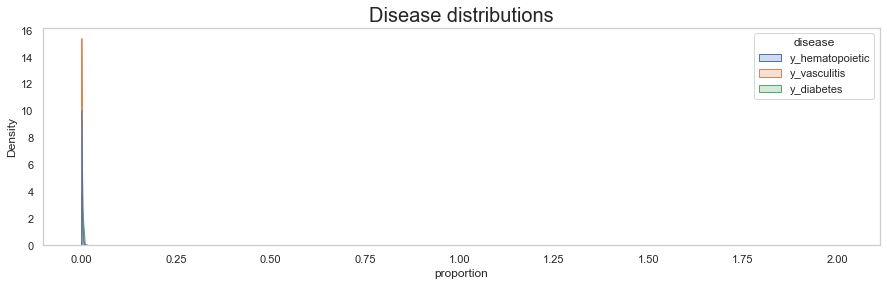

In [64]:
df_melt = pd.melt(df, 
              value_vars=['y_hematopoietic', 'y_vasculitis', 'y_diabetes'], 
              var_name='disease', value_name='proportion')
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df_melt, x="proportion", hue='disease', bw_adjust=.8, fill=True)\
  .set_title("Disease distributions", size=20)
print('')

The plot of each disease individually is too hard to see also due to inflated 0's.

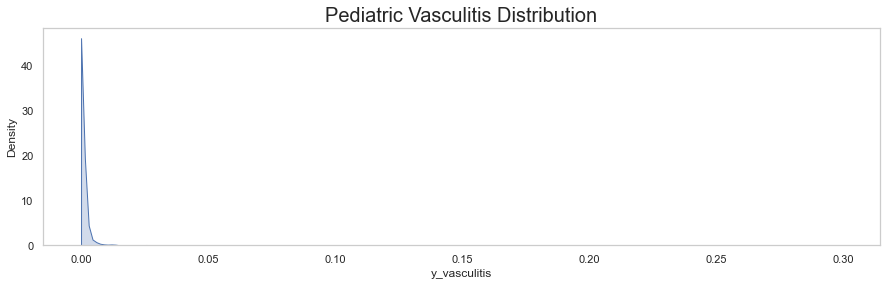

In [65]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df, x="y_vasculitis", bw_adjust=.8, fill=True)\
  .set_title("Pediatric Vasculitis Distribution", size=20)
print('')

Each disease distribution is heavily skewed left, with most values very close to 0. 

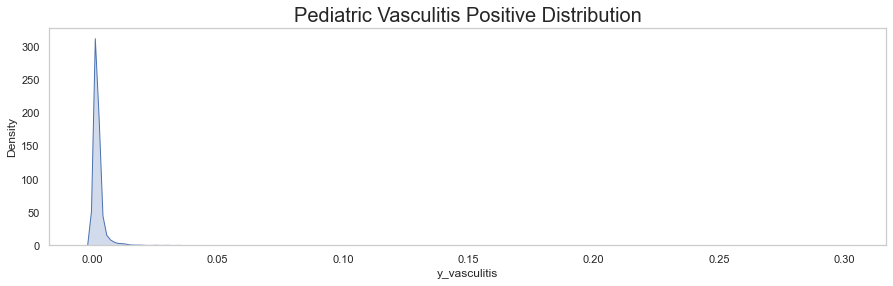

In [66]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df[df['y_vasculitis']>0], x="y_vasculitis", bw_adjust=.8, fill=True)\
  .set_title("Pediatric Vasculitis Positive Distribution", size=20)
print('')

Plotting the log of each disease distribution, looking at positive cases only is much easier to visualize:

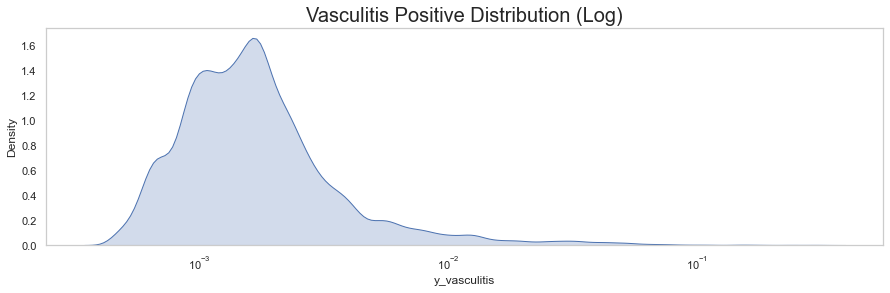

In [67]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df[df['y_vasculitis']>0], x="y_vasculitis", bw_adjust=.8, fill=True, log_scale=True)\
  .set_title("Vasculitis Positive Distribution (Log)", size=20)
print('')

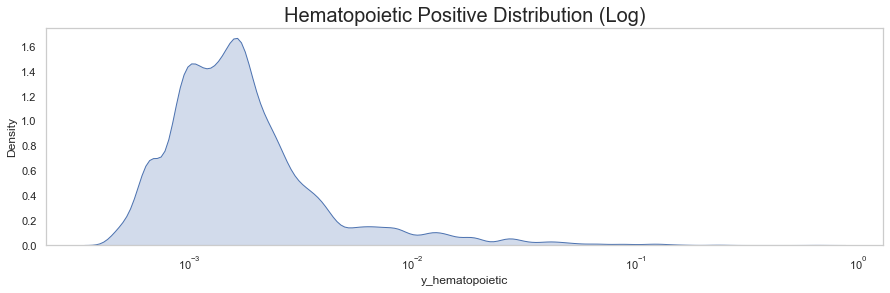

In [68]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df[df['y_hematopoietic']>0], x="y_hematopoietic", bw_adjust=.8, fill=True, log_scale=True)\
  .set_title("Hematopoietic Positive Distribution (Log)", size=20)
print('')

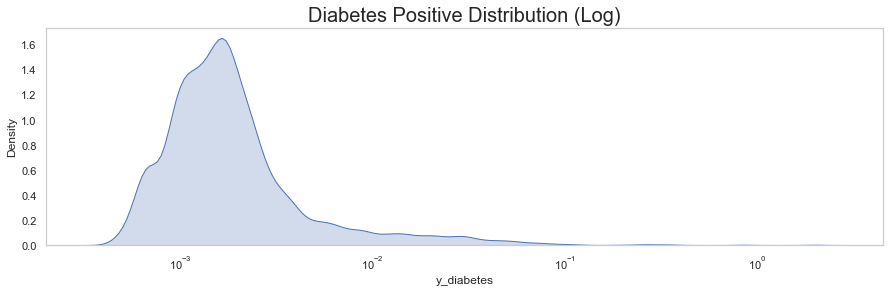

In [69]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df[df['y_diabetes']>0], x="y_diabetes", bw_adjust=.8, fill=True, log_scale=True)\
  .set_title("Diabetes Positive Distribution (Log)", size=20)
print('')

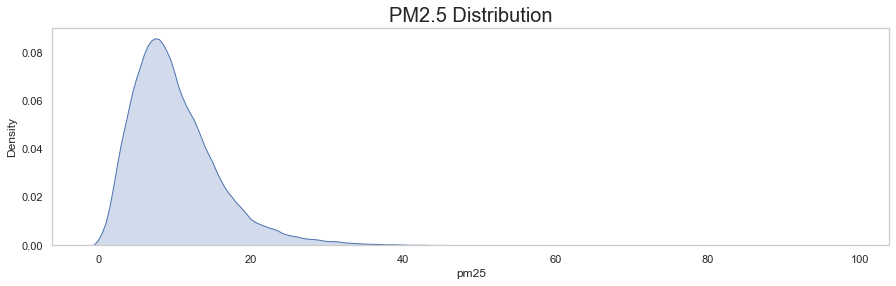

In [70]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df, x="pm25", bw_adjust=.8, fill=True)\
  .set_title("PM2.5 Distribution", size=20)
print('')

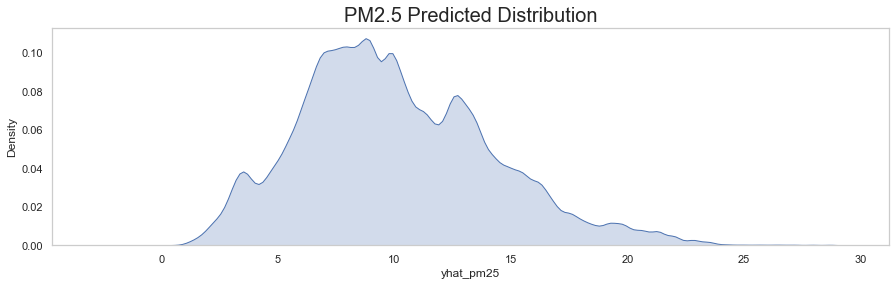

In [71]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df, x="yhat_pm25", bw_adjust=.8, fill=True)\
  .set_title("PM2.5 Predicted Distribution", size=20)
print('')

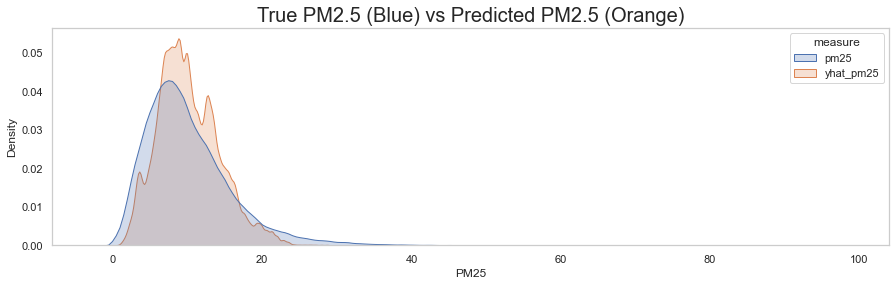

In [72]:
df_melt = pd.melt(df, 
              value_vars=['pm25', 'yhat_pm25'], 
              var_name='measure', value_name='PM25')
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df_melt, x="PM25", hue='measure', bw_adjust=.8, fill=True)\
  .set_title("True PM2.5 (Blue) vs Predicted PM2.5 (Orange)", size=20)
print('')

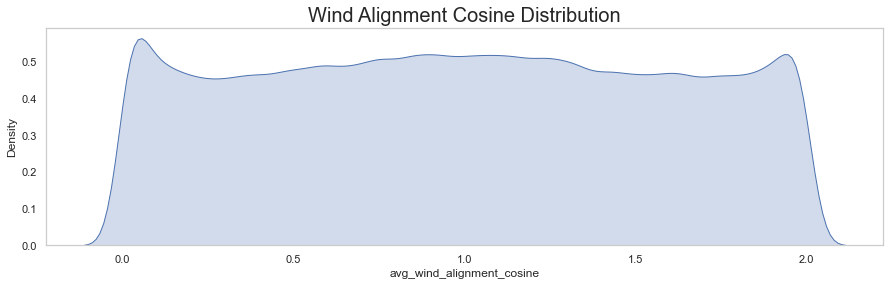

In [73]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df, x="avg_wind_alignment_cosine", bw_adjust=.8, fill=True)\
  .set_title("Wind Alignment Cosine Distribution", size=20)
print('')